# Renormalization group

Given the quantum Ising Hamiltonian in transverse field on a one-dimensional lattice with nearest neighbor interaction:
$$
\hat{H} = \lambda \sum_{i=1}^{N} \sigma_z^{(i)} + \sum_{i=1}^{N-1} \sigma_x^{(i)} \sigma_x^{(i+1)}
$$

where $ \sigma_x $ and $ \sigma_z $ are the Pauli matrices and $ \lambda $ is the transverse field.

1. Compute the ground state energy as a function of the transverse field $ \lambda $ by means of the real-space RG algorithm.
2. Compute the ground state energy as a function of $ \lambda $ by means of the INFINITE DMRG algorithm.
3. Compare the results between them and with the mean field solution.

In [94]:
# ===========================================================================================================
# IMPORT ZONE
# ===========================================================================================================

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

# ===========================================================================================================
# ISING MODEL
# ===========================================================================================================

def pauli_matrices():
  """
  pauli_matrices:
    Builds the Pauli matrices as sparse matrices.

  Returns
  -------
  s_x, s_y, s_z: tuple of sp.csr_matrix
    Pauli matrices for a 2x2 system in sparse format.
  """
  s_x = sp.csr_matrix([[0, 1], [1, 0]], dtype=complex)
  s_y = sp.csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
  s_z = sp.csr_matrix([[1, 0], [0, -1]], dtype=complex)
  return s_x, s_y, s_z

# ===========================================================================================================

def ising_hamiltonian(N, l):
  """
  ising_hamiltonian:
    Builds the Ising model Hamiltonian using sparse matrices.

  Parameters
  ----------
  N : int
    Number of spins.
  l : float
    Interaction strength.

  Returns
  -------
  H : sp.csr_matrix
    Sparse Ising Hamiltonian.
  """
  dim = 2 ** N
  H_nonint = sp.csr_matrix((dim, dim), dtype=complex)
  H_int = sp.csr_matrix((dim, dim), dtype=complex)
  
  s_x, _, s_z = pauli_matrices()
  
  for i in range(N):
    zterm = sp.kron(sp.identity(2**i, format='csr'), sp.kron(s_z, sp.identity(2**(N - i - 1), format='csr')))
    H_nonint += zterm
    
  for i in range(N - 1):
    xterm = sp.kron(sp.identity(2**i, format='csr'), sp.kron(s_x, sp.kron(s_x, sp.identity(2**(N - i - 2), format='csr'))))
    H_int += xterm
  
  H = H_int + l * H_nonint
  return H

# ===========================================================================================================

def projector(H, d_eff):
  _, eigvecs = sp.linalg.eigsh(H, k=d_eff, which='SA')  # Compute the smallest `k` eigenvalues
    
  proj = sp.csr_matrix(eigvecs)

  return proj

# ===========================================================================================================

def initialize_A_B(N):
  s_x, _, _ = pauli_matrices()
  
  A_0 = sp.kron(sp.identity(2**(N - 1), format='csr'), s_x)
  B_0 = sp.kron(s_x, sp.identity(2**(N - 1), format='csr'))
  
  return A_0, B_0

# ===========================================================================================================

def compute_H_2N(N, H, A, B):  
  H_2N = sp.kron(H, sp.identity(2**(N), format='csr')) + sp.kron(sp.identity(2**(N), format='csr'), H) + sp.kron(A, B)
  return H_2N

# ===========================================================================================================

def update_operators(N, H_2N, A, B):
  P = projector(H_2N, d_eff=2**N)
  
  P_dagger = P.conj().T
  I_N = sp.identity(2**N, format='csr')

  # Compute H_Nnn, Ann, Bnn, Pnn
  H_eff = 1 / 2 * P_dagger @ H_2N @ P
  A_eff = 1 / np.sqrt(2) * P_dagger @ sp.kron(I_N, A) @ P
  B_eff = 1 / np.sqrt(2) * P_dagger @ sp.kron(B, I_N) @ P
  
  return H_eff, A_eff, B_eff, P

# ===========================================================================================================
  
def real_space_rg(N, l, threshold, d_eff, max_iter=100):
  prev_energy_density = 10
  H = ising_hamiltonian(N, l)
  A, B = initialize_A_B(N)

  for iteration in range(1, max_iter + 1):
    H_2N = compute_H_2N(N, H, A, B)
    
    # Compute the current energy density and eigenvectors
    eigvals, eigvecs = sp.linalg.eigsh(H_2N, k=d_eff, which='SA')
    current_energy_density = eigvals[0]

    # Check for convergence 
    delta = abs(current_energy_density - prev_energy_density)

    if delta > threshold:
      H, A, B, P = update_operators(N, H_2N, A, B)
    else:
      print(f"Convergence achieved at iteration {iteration}: ε = {current_energy_density}")
      break

    # Update previous energy density for next iteration
    prev_energy_density = current_energy_density

  return eigvals[0], eigvecs[:, 0]


# ===========================================================================================================

def update_hamiltonian(N_values, l_values, threshold, max_iter=100):
  # Initialize dictionaries to store eigenvalues and eigenvectors
  eigenvalues_dict = {}
  eigenvectors_dict = {}
  
  for N in N_values:
    print(f"Analysis with N={N}...")

    for l in l_values:      
      d_eff = 2**N    
      eigvals, eigvecs = real_space_rg(N, l, threshold, d_eff, max_iter)  
      
      eigenvalues_dict[(2*N, l)] = eigvals
      eigenvectors_dict[(2*N, l)] = eigvecs
    
    print("-----------------------------------------")
    
  return eigenvalues_dict, eigenvectors_dict

In [95]:
# Parameters
N_vals = np.arange(1, 2, 1)
l_vals = np.linspace(-3, 0, 10)
threshold = 1e-3
max_iter = 200

eigenvalues, eigenvectors = update_hamiltonian(N_vals, l_vals, threshold, max_iter)

Analysis with N=1...
Convergence achieved at iteration 4: ε = -6.102721100323247
Convergence achieved at iteration 4: ε = -5.450194918706135
Convergence achieved at iteration 4: ε = -4.802258953182081
Convergence achieved at iteration 5: ε = -4.1618642197149525
Convergence achieved at iteration 5: ε = -3.53444395236105
Convergence achieved at iteration 8: ε = -2.9356957872573086
Convergence achieved at iteration 10: ε = -2.4473012122033317
Convergence achieved at iteration 11: ε = -2.1469143577213297
Convergence achieved at iteration 11: ε = -2.0161950938858344
Convergence achieved at iteration 12: ε = -2.077580542699191
-----------------------------------------


In [9]:
import phase_transition_functions as ptf
import ising_model as im

In [44]:
eigenvectors[(2, -3.0)]

array([-4.92069544e-01+8.70313094e-01j,  4.05231404e-15-1.27675648e-15j,
        2.38697950e-15-2.77555756e-16j, -2.04941433e-02+1.63439951e-03j])

In [27]:
def plot_eigenvalues(N_values, l_values, eigenvalues):
  # Loop over the values of N (many plots)
  for N in N_values:
    plt.figure(figsize=(8, 5))
      
    # Loop over the first k levels
    energies = []
    for l in l_values:
      energies.append(eigenvalues[(N, l)] / N)

    plt.plot(l_values, energies, label=f'N ={N}')
    
    plt.axvline(x = -1, linestyle="--", color = "red", label="Critical point")
        
    # Plot formatting
    plt.xlabel('Interaction strength (λ)')
    plt.ylabel('Energy')
    plt.title(f'Ground state energy vs λ (N={N})')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

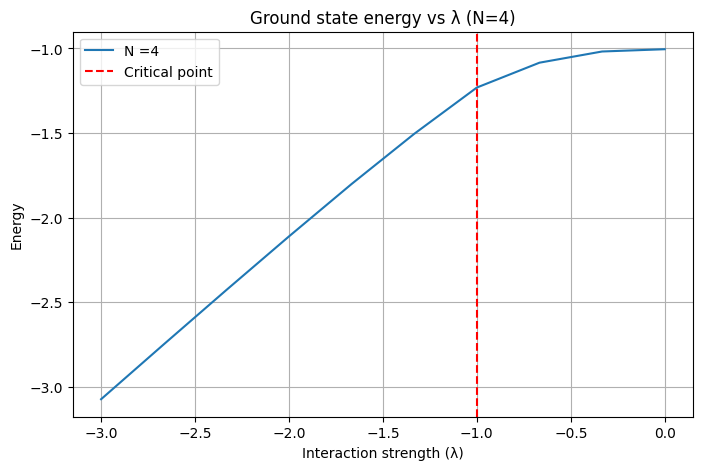

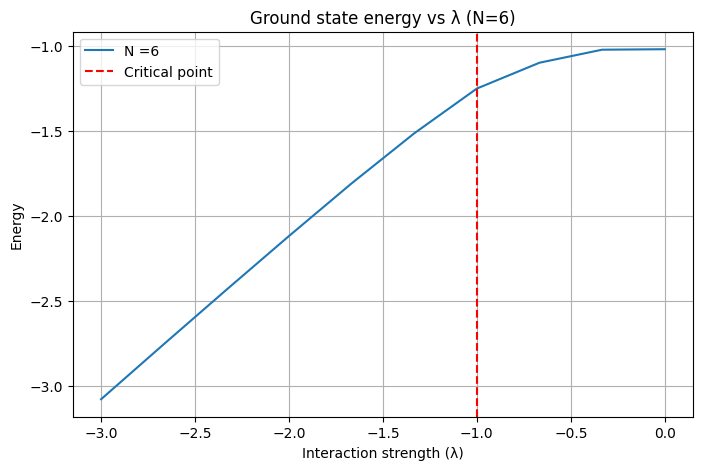

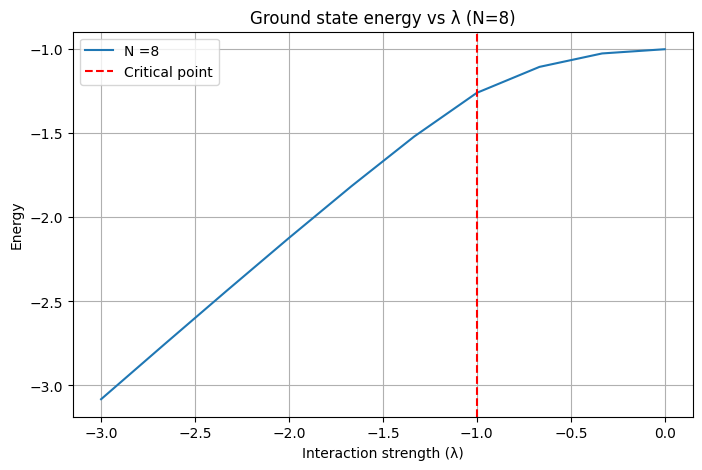

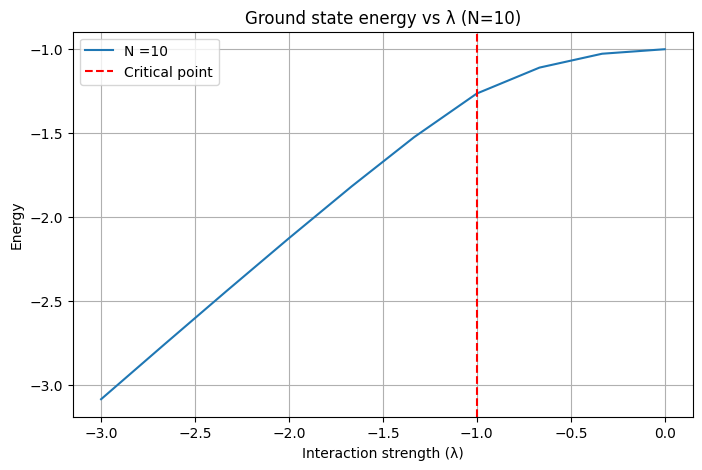

In [28]:
plot_eigenvalues(2*N_vals, l_vals, eigenvalues)

In [76]:
def magnetization(ground_state, N):
  """
  magnetization:
    Computes the magnetization of the ground state vector for an N-spin system.

  Parameters
  ----------
  ground_state : np.ndarray
    Ground state vector of the system.
  N : int
    Number of spins in the system.

  Returns
  -------
  M : float
    Expectation value of the normalized total magnetization operator.
  """
  _, _, s_z = im.pauli_matrices()  # Retrieve sparse Pauli matrices
  
  M_z = sp.csr_matrix((2**N, 2**N), dtype=complex)
  
  for i in range(N):
    M_z_i = sp.kron(sp.identity(2**i, format='csr'), sp.kron(s_z, sp.identity(2**(N - i - 1), format='csr')))
    M_z += M_z_i
    
  M_z /= N
  
  M = ground_state.conj().transpose().dot(M_z.dot(ground_state))
  return M

# ===========================================================================================================

def plot_magnetization(N_values, l_values, eigenvectors):
  """
  plot_magnetization :
    Plot the magnetization as a function of l for different N.
  
  Parameters
  ----------
  N_values : list of int
    Values of N, number of spins in the system.
  l_values : list of float
    Values of l, interaction strength.
  eigenvecttors : np.ndarray
    Precomputed eigenvectors for every (N, l).
  
  Returns
  -------
  None
  """  
  plt.figure(figsize=(8, 5))
    
  # Loop over the values of N (many plots)
  for N in N_values:    
    Ms = []
    # Loop over the first k levels
    for l in l_values:
      M = magnetization(eigenvectors[(N, l)], N)
      Ms.append(M)

    plt.plot(l_values, Ms, marker='^', linestyle='--', label = f"N={N}", markersize=3)
  
  plt.axvline(x=1, linestyle="--", color="red", label="Critical point")
      
  # Plot formatting
  plt.xlabel('Interaction strength (λ)')
  plt.ylabel('Magnetization')
  plt.title(f'Magnetization vs λ')
  #plt.xscale('log')
  plt.legend(loc="lower left")
  plt.grid()
  plt.show()

In [80]:
# Parameters
N_vals = np.arange(3, 4, 1)
l_vals = np.linspace(0.9, 1.3, 20)
threshold = 1e-4
max_iter = 200

eigenvalues, eigenvectors = update_hamiltonian(N_vals, l_vals, threshold, max_iter)

Analysis with N=3...
Convergence achieved at iteration 12: ε = -7.171100957198481
Convergence achieved at iteration 12: ε = -7.236011296871022
Convergence achieved at iteration 11: ε = -7.300945271451419
Convergence achieved at iteration 8: ε = -7.368548013550749
Convergence achieved at iteration 7: ε = -7.447741356969513
Convergence achieved at iteration 7: ε = -7.531349024850463
Convergence achieved at iteration 7: ε = -7.617872762239333
Convergence achieved at iteration 7: ε = -7.707656792932178
Convergence achieved at iteration 7: ε = -7.804881708911233
Convergence achieved at iteration 7: ε = -7.900698789377934
Convergence achieved at iteration 7: ε = -7.996223607849101
Convergence achieved at iteration 6: ε = -8.0932719238579
Convergence achieved at iteration 6: ε = -8.19213735248397
Convergence achieved at iteration 6: ε = -8.291850993837926
Convergence achieved at iteration 6: ε = -8.392759485922582
Convergence achieved at iteration 6: ε = -8.503658731115697
Convergence achieve

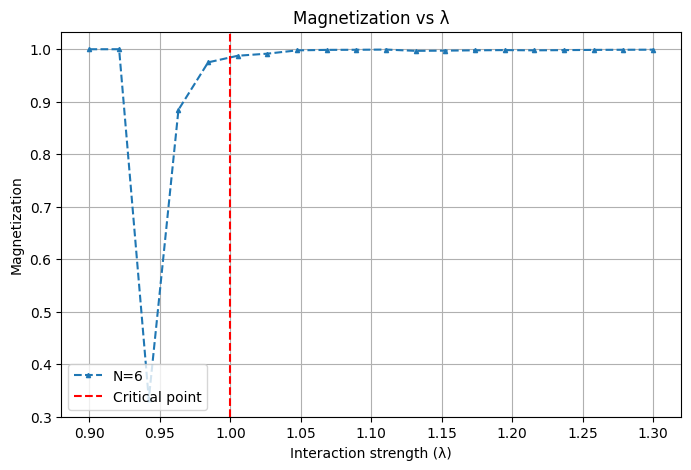

In [81]:
plot_magnetization(2*N_vals, l_vals, eigenvectors)

**Infinite DMRG**

In [97]:
# ===========================================================================================================

def initialize_A_B(m):
  s_x, _, _ = pauli_matrices()
  
  A_0 = sp.identity(2**(m - 1), format='csr')
  B_0 = sp.kron(s_x, sp.identity(2**(m - 1), format='csr'))
  
  return A_0, B_0

# ===========================================================================================================

def compute_H_LR(H_L, H_R, A, B, l):
  s_x, _, s_z = pauli_matrices()
  H_L1 = sp.kron(H_L, sp.identity(2, format='csr')) + sp.kron(A, l * s_z) + sp.kron(B, s_x)
  H_R1 = sp.kron(sp.identity(2, format='csr'), H_R) + sp.kron(l * s_z, A) + sp.kron(s_x, B)
  return H_L1, H_R1

# ===========================================================================================================

def update_operators(m):
  s_x, _, _ = pauli_matrices()
  A_eff = sp.identity(2**m, format='csr')
  B_eff = sp.kron(sp.identity(2**(m-1), format='csr'), s_x)
  
  return A_eff, B_eff

# ===========================================================================================================

def compute_H_2m(H_L1, H_R1):
  s_x, _, _ = pauli_matrices()
  H_LR = sp.kron(s_x, s_x)
  
  H_2m = sp.kron(H_L1, sp.identity(H_R1.shape[0], format='csr')) + sp.kron(sp.identity(H_L1.shape[0], format='csr'), H_R1) + H_LR
  
  return H_2m

# ===========================================================================================================
  
def rdm(psi, N, D, keep_indices):
  """
  rdm :
    Computes the reduced density matrix of a quantum state by tracing out the 
    degrees of freedom of the environment.

  Parameters
  ----------
  psi : np.ndarray
    Wavefunction of the quantum many-body system, represented as a complex vector of 
    size D^N.
  N : int
    Number of subsystems.
  D : int
    Dimension of each subsystem.
  keep_indices : list of int
    Indices of the sites to retain in the subsystem (all other sites are traced out).

  Returns
  -------
  rdm : np.ndarray
    Reduced density matrix for the subsystem specified by keep_indices, which is a 
    square matrix of size (D^len(keep_indices), D^len(keep_indices)).
  """
  # Check correct values for 'keep_indices'
  if not all(0 <= idx < N for idx in keep_indices):
    raise ValueError(f"'keep_indices' must be valid indices within range(n_sites), got {keep_indices}")
    
  # Compute subsystem and environment dimensions
  n_keep = len(keep_indices)
  subsystem_dim = D ** n_keep
  env_dim = D ** (N - n_keep)

  # Reshape the wavefunction into a sparse tensor (use csr_matrix for efficient sparse storage)
  psi_tensor = sp.csr_matrix(psi.reshape([D] * N))

  # Reorder the axes to group subsystem (first) and environment (second)
  all_indices = list(range(N))
  env_indices = [i for i in all_indices if i not in keep_indices]  # complement of keep_indices
  reordered_tensor = np.transpose(psi_tensor, axes=keep_indices + env_indices)

  # Partition into subsystem and environment (reshape back)
  psi_partitioned = reordered_tensor.reshape((subsystem_dim, env_dim))

  # Compute the reduced density matrix (use sparse matrix multiplication)
  rdm = psi_partitioned.dot(psi_partitioned.conj().T)

  return rdm

# ===========================================================================================================

def projector(rho_L, k):
  _, eigvecs = sp.linalg.eigsh(rho_L, k=k, which='LA')  # Compute the largest `k` eigenvalues
    
  proj = sp.csr_matrix(eigvecs)

  return proj

# ===========================================================================================================

def update_hamiltonian(N, l_values, threshold, d_eff, max_iter=100):
  # Initialize dictionaries to store eigenvalues and eigenvectors
  eigenvalues_dict = {}
  eigenvectors_dict = {}
  
  for l in l_values:
    print(f"Analysis with l={l}")
    
    prev_energy_density = 10
    H = ising_hamiltonian(N, l)
    A, B = initialize_A_B(N)

    # Build Hamiltonian of size 2N and projector
    H_2N = compute_H_2N(N, H, A, B)

    for iteration in range(1, max_iter + 1):
      # Compute the current energy density and eigenvectors
      eigvals, eigvecs = sp.linalg.eigsh(H_2N, k=d_eff, which='SA')
      current_energy_density = eigvals[0]
      
      # Save eigenvalues and eigenvectors in dictionaries with the key (2**iteration, l)
      eigenvalues_dict[(2**iteration, l)] = eigvals
      eigenvectors_dict[(2**iteration, l)] = eigvecs  # Save all eigenvectors, or choose a subset if needed

      # Check for convergence 
      delta = abs(current_energy_density - prev_energy_density)

      if delta > threshold:
        H, A, B, P = update_operators(N, H_2N, A, B)
      else:
        print(f"Convergence achieved at iteration {iteration}: ε = {current_energy_density}")
        break

      # Update previous energy density for next iteration
      prev_energy_density = current_energy_density

      # Compute new H_2N and P
      H_2N = compute_H_2N(N, H, A, B)
    
    print("-----------------------------------------")
    
  return eigenvalues_dict, eigenvectors_dict


# ===========================================================================================================

